In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import itertools

import os, sys
sys.path.append("../")

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler

from AdversarialGame.classifiers import CostSensitiveSequenceTagger

from analysis.utils import compute_feature_distances
from hapt_experiment.run_experiment import load_hapt_data, preprocess


/Users/kaiser/anaconda3/envs/cvxopt/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
X_tr, y_tr, X_ts, y_ts = load_hapt_data()

In [5]:
X_tr, X_ts, X_comb_tr, X_comb_ts, _ = preprocess(X_tr, X_ts)

In [6]:
print (len(X_tr), len(y_tr), len(X_ts), len(y_ts))

63 63 25 25


In [7]:
labels = []
with open('/Users/kaiser/Downloads/Dataset/Sequence/HAPT Data Set/activity_labels.txt', 'rt') as f:
    for line in f.readlines():
        labels.append (line.strip().split()[1].lower())

In [ ]:
cm1, cm2, fig = compute_feature_distances(X_comb_tr, np.concatenate(y_tr), classes=labels, size=(20, 20))
print (cm1)
print (cm2)
plt.show()
# fig.savefig('cost_matrices.png')


In [ ]:
for row in cm2:
    print (",".join(["%.2f"%v for v in row]))

In [ ]:
cm3 = (cm2-1) / cm2.max() + 1
cm3[cm3 < 1] = 0
for row in cm3:
    print (",".join(["%.2f"%v for v in row]))

In [ ]:
def count_sequence(y):
    ret = []
    count = 1
    for i in range(len(y) - 1):
        if y[i] == y[i+1]: count += 1
        else:
            ret.append((y[i], count))
            count = 1
    ret.append((y[-1], count))
    return ret
    
for y in y_tr:
    print ( count_sequence(y) )

In [ ]:
%%time
# now create classifier and train
cost_matrix = 1 - np.eye(12)
y_seq = [y-1 for y in y_tr]
ast = CostSensitiveSequenceTagger(cost_matrix=cost_matrix, max_itr=3)
ast.fit(X_tr, y_seq)

plt.plot(ast.epoch_times, ast.average_objective);

# predict
y_pred = [y+1 for y in ast.predict(X_ts)]
print(metrics.accuracy_score(np.concatenate(y_ts), np.concatenate(y_pred)))

In [ ]:
X_tr, y_tr, X_ts, y_ts = load_hapt_data() # changed the split file name above, should have a new seq
X_tr, X_ts, _, _ = preprocess(X_tr, X_ts)
print (len(X_tr), len(y_tr), len(X_ts), len(y_ts))

In [ ]:
%%time
# now create classifier and train
cost_matrix = 1 - np.eye(12)
y_seq = [y-1 for y in y_tr]
ast = CostSensitiveSequenceTagger(cost_matrix=cost_matrix, max_itr=3)
ast.fit(X_tr, y_seq)

plt.plot(ast.epoch_times, ast.average_objective);

# predict
y_pred = [y+1 for y in ast.predict(X_ts)]
print(metrics.accuracy_score(np.concatenate(y_ts), np.concatenate(y_pred)))

In [ ]:
for row in 1-np.eye(12):
    print (",".join(["%.2f"%v for v in row]))

In [ ]:
train_obj = np.loadtxt('../output/hapt/from_pur02_190302/adv_01/training_objectives.txt', delimiter=',')
plt.plot(train_obj[:,0], train_obj[:,1]);

In [ ]:
predict_res = np.loadtxt('../output/hapt/from_pur02_190302/adv_01/prediction_result.txt', delimiter=',')
tmp = predict_res.sum(axis=0)
tmp[1] / tmp[0]

In [ ]:
train_obj = np.loadtxt('../output/hapt/from_pur01_190302/reg0.1_lr0.1_loss01/training_objectives.txt', delimiter=',')
plt.plot(train_obj[:,0], train_obj[:,1]);
predict_res = np.loadtxt('../output/hapt/from_pur01_190302/reg0.1_lr0.1_loss01/prediction_result.txt', delimiter=',')
tmp = predict_res.sum(axis=0)
print (tmp[1] / tmp[0])

In [10]:
## check the 0-1 loss for logistic regression
# load the sequence labels 
lr_preds = []
lr_bayes = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/lr/predictions.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        pre, line = line[:5], line[6:]
        if pre == 'p_max': lr_preds.append(np.array(line.split(','), dtype=int))
        if pre == 'bayes': lr_bayes.append(np.array(line.split(','), dtype=int))

for i, (y_p, y_b, y_t) in enumerate(zip(lr_preds, lr_bayes, y_ts)):
    diff, p_diff, b_diff = (y_p!=y_b).sum(), (y_p!=y_t).sum(), (y_b!=y_t).sum()
    if diff:
        print (i, diff, p_diff, b_diff)
        print (y_p)
        print (y_b)
        print (y_t)

for i, l in enumerate(labels):
    print (i+1, l)
    
# anomaly 1:
# anotated true label: laying -> lie-to-stand -> walking -> walking
# non cost: laying -> lie-to-stand -> lie-to-sit -> walking_downstairs -> walking
# cost: laying -> lie-to-stand -> lie-to-sit -> walking -> walking
# anomaly 2:
# anotated true label: sitting -> sit-to-lie -> sit-to-lie
# non cost: sitting -> sit-to-lie -> stand-to-lie
# cost: sitting -> stand-to-lie -> stand-to-lie

cm3 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/hapt_experiment/cost_distance_scaled.txt', delimiter=',')
print ('non-cost_sensitive:', cm3[np.concatenate(lr_preds)-1, np.concatenate(y_ts)-1].sum())
print ('cost_sensitive:', cm3[np.concatenate(lr_bayes)-1, np.concatenate(y_ts)-1].sum())


19 1 7 7
[ 6  6  6  6  6  6  6  6 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  2  2  2  2  2  2  2  2  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  7  7  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 11 11  9  9  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6 10 10  4  4  4  4  4
  5  4  4  4  4  4  4  4  4  4  4  4  4  4 11 11  6  6  6  6  6  6  6  6
  6  6  6  6  6]
[ 6  6  6  6  6  6  6  6 10  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  3  3  3  3  3  3  3  2  2  2  2  2
  2  2  2  3  3  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  2  2  2  2  2  2  2  2  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  7  7  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  5  5  5  5  5  5  5 

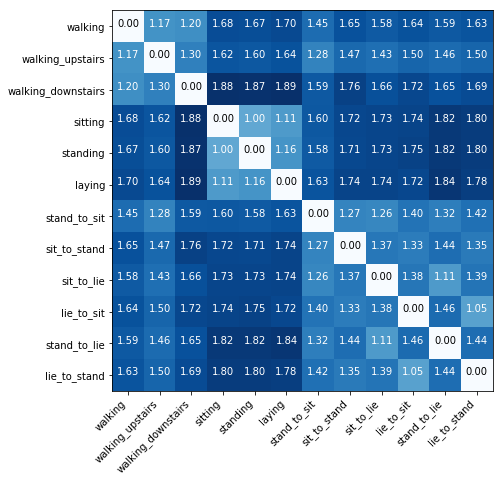

In [25]:
cm3 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/hapt_experiment/cost_distance_scaled.txt', delimiter=',')

fig = plt.figure(figsize=(7,7))

plt.imshow(cm3, interpolation='nearest' , cmap=plt.get_cmap('Blues'))
# plt.title('Class Distances')
tick_marks = np.arange(12)
plt.xticks(tick_marks, labels, rotation=45, ha='right')
plt.yticks(tick_marks, labels)

fmt = '.2f'
thresh = cm3.max() / 2.
for i, j in itertools.product(range(12), range(12)):
    plt.text(j, i, format(cm3[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm3[i, j] > thresh else "black")

# plt.tight_layout()
plt.show()

In [7]:
cm3 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/hapt_experiment/cost_distance_scaled.txt', delimiter=',')

adv_01_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_loss01/predictions.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        adv_01_preds.append(np.array(line.split(','), dtype=int))
        
adv_scaled_dist_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_scaledloss/predictions.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        adv_scaled_dist_preds.append(np.array(line.split(','), dtype=int))
        

p_hat_01 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_loss01/p_hat.txt', delimiter=',')
tmp = p_hat_01.argmax(axis=1) + 1     
y_hat_01 = []
start = 0
for l in [len(y) for y in y_ts]:
    y_hat_01.append(tmp[start:start+l])
    start += l


p_hat_scaled = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_scaledloss/p_hat.txt', delimiter=',')
tmp = p_hat_scaled.argmax(axis=1) + 1      
y_hat_scaled = []
start = 0
for l in [len(y) for y in y_ts]:
    y_hat_scaled.append(tmp[start:start+l])
    start += l     

    
exp_01, exp_scaled = 0., 0.
y = np.concatenate(y_ts) - 1
for i in range(len(p_hat_01)):
    exp_01 += np.dot(p_hat_01[i], cm3[:, y[i]])
    exp_scaled += np.dot(p_hat_scaled[i], cm3[:, y[i]])
print ('non-cost_sensitive:', cm3[np.concatenate(adv_01_preds)-1, np.concatenate(y_ts)-1].sum())
print ('cost_sensitive:', cm3[np.concatenate(adv_scaled_dist_preds)-1, np.concatenate(y_ts)-1].sum())
print ('non-cost_sensitive (yhat):', cm3[np.concatenate(y_hat_01)-1, np.concatenate(y_ts)-1].sum(),
       exp_01
      )
print ('cost_sensitive (yhat):', cm3[np.concatenate(y_hat_scaled)-1, np.concatenate(y_ts)-1].sum(),
       exp_scaled
      )

        
for i, (y_p1, y_p2, y_t) in enumerate(zip(adv_01_preds, adv_scaled_dist_preds, y_ts)):
    diff1, diff2 = (y_p1!=y_t).sum(), (y_p2!=y_t).sum()
    if diff1 or diff2:
        print (i, diff1, diff2)
        combined = np.column_stack( ((y_p1 - y_p2), y_p1, y_p2, y_t, cm3[y_p1-1, y_t-1], cm3[y_p2-1, y_t-1]) )
        if combined[:,0].any():
            # find consecutive nonzero-col-1 rows preceeding by 0 and ending by 0
            for i in range(len(combined)):
                if (combined[i, 0] or 
                    (i < len(combined)-1 and combined[i+1, 0]) or 
                     (i > 0 and combined[i-1, 0])
                    ):
                    print (i, combined[i])
            print ( "\n---")

        
for i, l in enumerate(labels):
    print (i+1, l)



non-cost_sensitive: 106.99000000000001
cost_sensitive: 102.15
non-cost_sensitive (yhat): 212.49 207.985850003053
cost_sensitive (yhat): 187.26 198.5878562950017
0 2 3
48 [ 0. 11. 11. 11.  0.  0.]
49 [ 2.   11.    9.   11.    0.    1.11]
50 [ 0.    9.    9.   11.    1.11  1.11]

---
3 1 1
4 10 10
6 11 11
7 12 11
59 [0. 4. 4. 4. 0. 0.]
60 [ 2.   11.    9.    9.    1.11  0.  ]
61 [0. 6. 6. 6. 0. 0.]

---
9 1 1
10 13 13
30 [0. 4. 4. 4. 0. 0.]
31 [-1.  4.  5.  4.  0.  1.]
32 [0. 5. 5. 4. 1. 1.]
97 [0. 6. 6. 6. 0. 0.]
98 [-1.   11.   12.   12.    1.44  0.  ]
99 [0. 1. 1. 1. 0. 0.]

---
11 8 6
87 [0. 6. 6. 6. 0. 0.]
88 [-2.   10.   12.   12.    1.05  0.  ]
89 [-2.   10.   12.   12.    1.05  0.  ]
90 [0. 1. 1. 1. 0. 0.]

---
12 1 1
13 6 4
59 [0. 6. 6. 6. 0. 0.]
60 [-2.   10.   12.   10.    0.    1.05]
61 [0. 4. 4. 4. 0. 0.]
91 [0. 6. 6. 6. 0. 0.]
92 [-2.   10.   12.   12.    1.05  0.  ]
93 [-2.   10.   12.   12.    1.05  0.  ]
94 [-1.   11.   12.   12.    1.44  0.  ]
95 [0. 1. 1. 1. 0. 0.]

--

In [6]:
cm3 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/hapt_experiment/cost_distance_scaled.txt', delimiter=',')

adv_01_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_loss01/predictions.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        adv_01_preds.append(np.array(line.split(','), dtype=int))
        
adv_scaled_dist_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_scaledloss/predictions.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        adv_scaled_dist_preds.append(np.array(line.split(','), dtype=int))

        
p_hat_01 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_loss01/p_hat.txt', delimiter=',')
tmp = p_hat_01.argmax(axis=1) + 1     
y_hat_01 = []
start = 0
for l in [len(y) for y in y_ts]:
    y_hat_01.append(tmp[start:start+l])
    start += l


p_hat_scaled = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_scaledloss/p_hat.txt', delimiter=',')
tmp = p_hat_scaled.argmax(axis=1) + 1      
y_hat_scaled = []
start = 0
for l in [len(y) for y in y_ts]:
    y_hat_scaled.append(tmp[start:start+l])
    start += l     

    
exp_01, exp_scaled = 0., 0.
y = np.concatenate(y_ts) - 1
for i in range(len(p_hat_01)):
#     print (i, y.shape, y[i], p_hat_01.shape, cm3.shape)        
    exp_01 += np.dot(p_hat_01[i], cm3[:, y[i]])
    exp_scaled += np.dot(p_hat_scaled[i], cm3[:, y[i]])
print ('non-cost_sensitive:', cm3[np.concatenate(adv_01_preds)-1, np.concatenate(y_ts)-1].sum())
print ('cost_sensitive:', cm3[np.concatenate(adv_scaled_dist_preds)-1, np.concatenate(y_ts)-1].sum())
print ('non-cost_sensitive (yhat):', cm3[np.concatenate(y_hat_01)-1, np.concatenate(y_ts)-1].sum(),
       exp_01
      )
print ('cost_sensitive (yhat):', cm3[np.concatenate(y_hat_scaled)-1, np.concatenate(y_ts)-1].sum(),
       exp_scaled
      )

        
for i, (y_p1, y_p2, y_t) in enumerate(zip(adv_01_preds, adv_scaled_dist_preds, y_ts)):
    diff1, diff2 = (y_p1!=y_t).sum(), (y_p2!=y_t).sum()
    if diff1 or diff2:
        print (i, diff1, diff2)
        combined = np.column_stack( ((y_p1 - y_p2), y_p1, y_p2, y_t, cm3[y_p1-1, y_t-1], cm3[y_p2-1, y_t-1]) )
        if combined[:,0].any():
            # find consecutive nonzero-col-1 rows preceeding by 0 and ending by 0
            for i in range(len(combined)):
                if (combined[i, 0] or 
                    (i < len(combined)-1 and combined[i+1, 0]) or 
                     (i > 0 and combined[i-1, 0])
                    ):
                    print (i, combined[i])
            print ( "\n---")

        
for i, l in enumerate(labels):
    print (i+1, l)


theta = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_scaledloss/theta.txt', delimiter=',')
transition_theta = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190306/reg.1_lr.1_scaledloss/transistion_theta.txt', delimiter=',')
ast = CostSensitiveSequenceTagger(cost_matrix=cm3, max_itr=3)
p, _ = ast.predict_proba_with_trained_theta(X_ts, cm3, theta, transition_theta)
    
# for row in np.column_stack((np.concatenate(adv_scaled_dist_preds), p_hat_scaled, np.concatenate(p, axis=0))):
#     print (row)
p_hat_scaled = np.concatenate(p, axis=0)
tmp = p_hat_scaled.argmax(axis=1) + 1      
phatC = np.dot(p_hat_scaled, cm3.T)

print ('cost_sensitive: (yhatCy)', cm3[tmp-1, np.concatenate(y_ts)-1].sum())    
print ('cost_sensitive: (phatCy)', sum( [pc[y-1] for pc,y in zip(phatC, y_ts)] ))


non-cost_sensitive: 106.99000000000001
cost_sensitive: 102.15
non-cost_sensitive (yhat): 212.49 207.985850003053
cost_sensitive (yhat): 187.26 198.5878562950017
0 2 3
48 [ 0. 11. 11. 11.  0.  0.]
49 [ 2.   11.    9.   11.    0.    1.11]
50 [ 0.    9.    9.   11.    1.11  1.11]

---
3 1 1
4 10 10
6 11 11
7 12 11
59 [0. 4. 4. 4. 0. 0.]
60 [ 2.   11.    9.    9.    1.11  0.  ]
61 [0. 6. 6. 6. 0. 0.]

---
9 1 1
10 13 13
30 [0. 4. 4. 4. 0. 0.]
31 [-1.  4.  5.  4.  0.  1.]
32 [0. 5. 5. 4. 1. 1.]
97 [0. 6. 6. 6. 0. 0.]
98 [-1.   11.   12.   12.    1.44  0.  ]
99 [0. 1. 1. 1. 0. 0.]

---
11 8 6
87 [0. 6. 6. 6. 0. 0.]
88 [-2.   10.   12.   12.    1.05  0.  ]
89 [-2.   10.   12.   12.    1.05  0.  ]
90 [0. 1. 1. 1. 0. 0.]

---
12 1 1
13 6 4
59 [0. 6. 6. 6. 0. 0.]
60 [-2.   10.   12.   10.    0.    1.05]
61 [0. 4. 4. 4. 0. 0.]
91 [0. 6. 6. 6. 0. 0.]
92 [-2.   10.   12.   12.    1.05  0.  ]
93 [-2.   10.   12.   12.    1.05  0.  ]
94 [-1.   11.   12.   12.    1.44  0.  ]
95 [0. 1. 1. 1. 0. 0.]

--

NameError: name 'p_hat' is not defined

In [13]:
phatC = np.dot(p_hat_scaled, cm3.T)

print ('cost_sensitive: (yhatCy)', cm3[tmp-1, np.concatenate(y_ts)-1].sum())    
print ('cost_sensitive: (phatCy)', sum( [pc[y-1] for pc,y in zip(phatC, np.concatenate(y_ts))] ))


cost_sensitive: (yhatCy) 150.35999999999999
cost_sensitive: (phatCy) 196.91066826097222


In [12]:
sum(cm3[np.concatenate(p, axis=0).argmax(axis=1), y]) / len(y)

0.06928842504743844

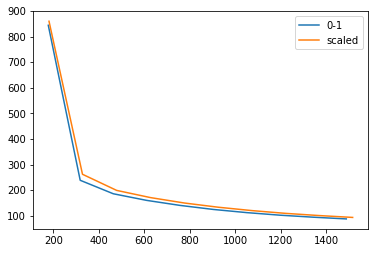

In [42]:
obj_01 = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190305/reg.1_lr0_loss01/training_objectives.txt', delimiter=',')
obj_scaled = np.loadtxt('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190305/reg.1_lr0_scaledloss/training_objectives.txt', delimiter=',')

plt.figure()
plt.plot(obj_01[:10,0], obj_01[:10,1])
plt.plot(obj_scaled[:10,0], obj_scaled[:10,1])
plt.legend(['0-1', 'scaled']);


In [54]:
svm_01_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190305/svm/01/prediction.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        svm_01_preds.append(np.array(line.split(','), dtype=int))
        
svm_scaled_dist_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190305/svm/scaledloss/prediction.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        svm_scaled_dist_preds.append(np.array(line.split(','), dtype=int))
        
svm_dist_preds = []
with open('/Users/kaiser/Documents/workspace_neon/Welding/output/hapt/190305/svm/loss/prediction.txt', 'rt') as f:
    for line in f.readlines():
        line = line.strip()
        svm_dist_preds.append(np.array(line.split(','), dtype=int))
        

print ('non-cost_sensitive:', cm3[np.concatenate(svm_01_preds)-1, np.concatenate(y_ts)-1].sum())
print ('cost_sensitive:', cm3[np.concatenate(svm_scaled_dist_preds)-1, np.concatenate(y_ts)-1].sum())
print ('cost_sensitive large:', cm3[np.concatenate(svm_dist_preds)-1, np.concatenate(y_ts)-1].sum())


for i, (y_p1, y_p2, y_t) in enumerate(zip(svm_01_preds, svm_scaled_dist_preds, y_ts)):
    diff1, diff2 = (y_p1!=y_t).sum(), (y_p2!=y_t).sum()
    if diff1 or diff2:
        print (i, diff1, diff2)
        combined = np.column_stack( ((y_p1 - y_p2), y_p1, y_p2, y_t, cm3[y_p1-1, y_t-1], cm3[y_p2-1, y_t-1]) )
        if combined[:,0].any():
            # find consecutive nonzero-col-1 rows preceeding by 0 and ending by 0
            for i in range(len(combined)):
                if (combined[i, 0] or 
                    (i < len(combined)-1 and combined[i+1, 0]) or 
                     (i > 0 and combined[i-1, 0])
                    ):
                    print (i, combined[i])
            print ( "\n---")

for i, l in enumerate(labels):
    print (i+1, l)

non-cost_sensitive: 136.28
cost_sensitive: 131.31
cost_sensitive large: 151.35000000000002
0 3 3
3 2 2
4 9 8
30 [0. 2. 2. 2. 0. 0.]
31 [ 6.   11.    5.    5.    1.82  0.  ]
32 [0. 5. 5. 5. 0. 0.]

---
6 19 19
7 15 16
1 [0. 5. 5. 5. 0. 0.]
2 [-7.    2.    9.    7.    1.28  1.26]
3 [0. 5. 5. 4. 1. 1.]
6 [0. 4. 4. 4. 0. 0.]
7 [2.   4.   2.   4.   0.   1.62]
8 [0.   2.   2.   4.   1.62 1.62]

---
9 1 0
66 [0. 4. 4. 4. 0. 0.]
67 [ 2.   11.    9.    9.    1.11  0.  ]
68 [0. 6. 6. 6. 0. 0.]

---
10 19 18
97 [0. 6. 6. 6. 0. 0.]
98 [-1.   11.   12.   12.    1.44  0.  ]
99 [0. 1. 1. 1. 0. 0.]

---
11 7 6
88 [ 0. 12. 12. 12.  0.  0.]
89 [-2.   10.   12.   12.    1.05  0.  ]
90 [0. 1. 1. 1. 0. 0.]

---
12 1 1
13 4 4
93 [ 0. 12. 12. 12.  0.  0.]
94 [-1.   11.   12.   12.    1.44  0.  ]
95 [0. 1. 1. 1. 0. 0.]
144 [0. 2. 2. 2. 0. 0.]
145 [1.  3.  2.  3.  0.  1.3]
146 [0. 3. 3. 3. 0. 0.]

---
14 1 1
15 1 1
16 1 3
15 [0. 2. 2. 2. 0. 0.]
16 [1.  3.  2.  3.  0.  1.3]
17 [0. 3. 3. 3. 0. 0.]
23 [0. 3. 3. 3

PolynomialFeatures {'degree': 3, 'include_bias': True, 'interaction_only': False}
RBFSampler {'gamma': 10, 'n_components': 10, 'random_state': 42}
10  features, 2  samples, 1000  epochs
gurobi pairwise marginals
cvxopt single oracle
10  features, 2  samples, 1000  epochs
gurobi pairwise marginals
cvxopt single oracle
[array([1, 1, 1]), array([2, 2, 2]), array([2, 2, 2])] 
 [array([1, 1, 1]), array([2, 2, 2]), array([2, 2, 2])] 
 [array([1, 1, 1]), array([2, 2, 2]), array([2, 2, 2])]
0.0 0.0
01
[[1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0.]]
[[2. 2. 0. 1. 0. 1.]
 [2. 2. 0. 1. 0. 1.]
 [2. 2. 0. 1. 0. 1.]]
[[2.     2.     0.     1.     0.5    0.5   ]
 [2.     2.     0.     1.     0.5    0.5   ]
 [2.     2.     0.2921 0.7079 0.5    0.5   ]]
cust1 
 [[0. 5.]
 [1. 0.]]
[[1.     1.     1.     0.     0.8333 0.1667]
 [1.     1.     1.     0.     0.8333 0.1667]
 [1.     1.     0.6803 0.3197 0.8333 0.1667]]
[[2. 2. 0. 1. 0. 1.]
 [2. 2. 0. 1. 0. 1.]
 [2. 2. 0. 1. 0. 1.]]
[[2.     2

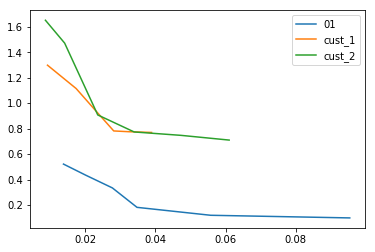

In [9]:
%%time
np.set_printoptions(precision=4, suppress=True)
from sklearn.preprocessing import PolynomialFeatures
# y = [np.array([1, 1, 1, 2]), np.array([1, 1, 2, 2]), np.array([1, 1, 2, 2]), np.array([1, 2, 2, 2])]
# X = [
#     np.array([[1., 1., 0.], [1., 2, 1], [1., 0, 1], [1., 1, 2]]),
#     np.array([[1., 1., 0.], [1., 2, 1], [1., 0, 1], [1., 1, 2]]),
#     np.array([[1., 1., 1.5], [1., 2, 2], [1., 3, 4], [1., 1, 1.5]]),
#     np.array([[1., 1., 1.5], [1., 2, 2], [1., 3, 4], [1., 1, 1.5]])
# ]
y = [np.array([1, 1, 1]), np.array([2, 2, 2])]
X = [
    np.array([[1., 1.], [1., 1.], [2., 2.]]),
    np.array([[1., 3.], [1., 3.], [1., 3.]])
]

X_ts = X + [np.array([[1., 3.], [1., 3.], [2., 3.]])]
y_ts = y + [np.array([2, 2, 2])]

poly = PolynomialFeatures(degree=3)
poly.fit(np.concatenate(X, axis=0))
print (poly.__class__.__name__, poly.get_params())
# X = [poly.transform(x) for x in X]
# X_ts = [poly.transform(x) for x in X_ts]

rbf_sampler = RBFSampler(gamma=10, n_components=10, random_state=42)
rbf_sampler.fit(np.concatenate(X, axis=0))
print (rbf_sampler.__class__.__name__, rbf_sampler.get_params(deep=False))
X = [rbf_sampler.transform(x) for x in X]
X_ts = [rbf_sampler.transform(x) for x in X_ts]

cost_01 = 1 - np.eye(2)
cost_cust = np.array([[0., 5], [1, 0]])

y_seq = [y_-1 for y_ in y]
ast = CostSensitiveSequenceTagger(cost_matrix=cost_01, max_itr=1000, max_update=10000000,
                                  solver='gurobi', learning_rate=0, reg_constant=.1, batch_size=100)

ast.fit(X, y_seq)
plt.plot(ast.epoch_times, ast.average_objective);
y_01 = [y_+1 for y_ in ast.predict(X_ts)]
p_01, q_01 = ast.predict_proba_with_trained_theta(X_ts, cost_01, ast.theta, ast.transition_theta)

ast.set_params(cost_matrix=cost_cust)
ast.fit(X, y_seq)

plt.plot(ast.epoch_times, ast.average_objective);
y_cust = [y_+1 for y_ in ast.predict(X_ts)]
p_cust, q_cust = ast.predict_proba_with_trained_theta(X_ts, cost_cust, ast.theta, ast.transition_theta)

print (y_01, "\n", y_cust, "\n", y_ts)
print (cost_cust[np.concatenate(y_01)-1, np.concatenate(y_ts)-1].sum(), 
       cost_cust[np.concatenate(y_cust)-1, np.concatenate(y_ts)-1].sum())
print ('01')
for y, l, p, q in zip(y_ts, y_01, p_01, q_01):
    print (np.column_stack((y, l.reshape(-1, 1), p, q)))
print('cust1', "\n", cost_cust)
for y, l, p, q in zip(y_ts, y_cust, p_cust, q_cust):
    print (np.column_stack((y, l.reshape(-1, 1), p, q)))


cost_cust = np.array([[0., 1], [5, 0]])
ast.set_params(cost_matrix=cost_cust)
ast.fit(X, y_seq)
plt.plot(ast.epoch_times, ast.average_objective);
y_cust = [y_+1 for y_ in ast.predict(X_ts)]
p_cust, q_cust = ast.predict_proba_with_trained_theta(X_ts, cost_cust, ast.theta, ast.transition_theta)

print (y_01, "\n", y_cust, "\n", y_ts)
print (cost_cust[np.concatenate(y_01)-1, np.concatenate(y_ts)-1].sum(), 
       cost_cust[np.concatenate(y_cust)-1, np.concatenate(y_ts)-1].sum())

print ('cust2', "\n", cost_cust)
for y, l, p, q in zip(y_ts, y_cust, p_cust, q_cust):
    print (np.column_stack((y, l.reshape(-1, 1), p, q)))
    
plt.legend(['01', 'cust_1', 'cust_2'])